<a href="https://colab.research.google.com/github/is0383kk/GMM-Gibbs/blob/main/gmm_gibbs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

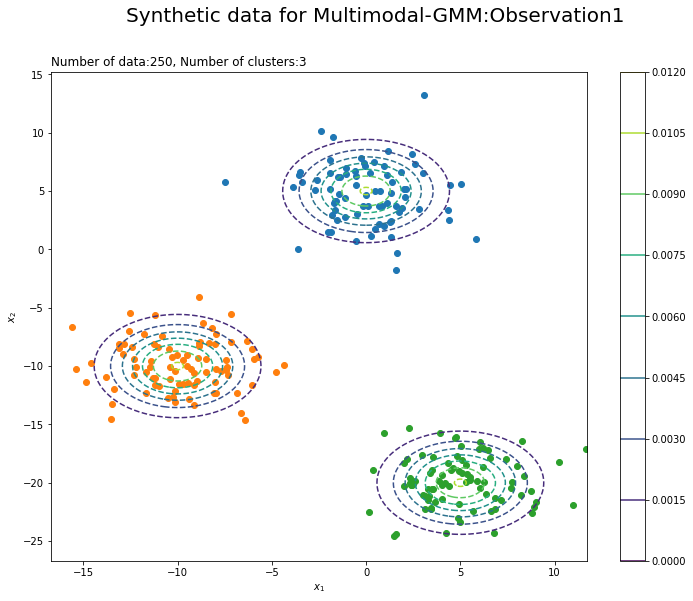

In [18]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

K = 3 # Number of clusters
N = 250 # Number of data
pi_synthetic_k = np.array([0.3333, 0.3333, 0.3333]) # Mixing ratio for synthetic data

#(This value when the number of clusters is 3)
# Specify mean parameter for generating synthetic data
mu_synthetic_kd_1 = np.array( # This is observation1
    [[0, 5.0], 
     [-10.0, -10.0], 
     [5.0, -20.0]]
)

# Specify covariance matrix parameters for generating synthetic data
sigma2_synthetic_kdd_1 = np.array( # This is observation1
    [[[5.0, 0], 
    [0, 5.0]],

     [[5.0, 0.0], 
     [0.0, 5.0]],

     [[5.0, 0.0], 
     [0.0, 5.0]]]
)

############################## Make synthetic data ##############################
z_synthetic_nk = np.random.multinomial(n=1, pvals=pi_synthetic_k, size=N)
_, z_synthetic_n = np.where(z_synthetic_nk == 1)
# x_nd_1 will be the observation1 of GMM
x_nd_1 = np.array([
    np.random.multivariate_normal(
        mean=mu_synthetic_kd_1[k], cov=sigma2_synthetic_kdd_1[k], size=1
    ).flatten() for k in z_synthetic_n
])

############################## Setting for graph ##############################
x_1_line_1 = np.linspace(
    np.min(mu_synthetic_kd_1[:, 0] - 3 * np.sqrt(sigma2_synthetic_kdd_1[:, 0, 0])), 
    np.max(mu_synthetic_kd_1[:, 0] + 3 * np.sqrt(sigma2_synthetic_kdd_1[:, 0, 0])), 
    num=300
)
x_2_line_1 = np.linspace(
    np.min(mu_synthetic_kd_1[:, 1] - 3 * np.sqrt(sigma2_synthetic_kdd_1[:, 1, 1])), 
    np.max(mu_synthetic_kd_1[:, 1] + 3 * np.sqrt(sigma2_synthetic_kdd_1[:, 1, 1])), 
    num=300
)
x_1_grid_1, x_2_grid_1 = np.meshgrid(x_1_line_1, x_2_line_1)
x_point_1 = np.stack([x_1_grid_1.flatten(), x_2_grid_1.flatten()], axis=1)
x_dim_1 = x_1_grid_1.shape



# Ovservation model
true_model_1 = 0
for k in range(K):
    tmp_density_1 = multivariate_normal.pdf(x=x_point_1, mean=mu_synthetic_kd_1[k], cov=sigma2_synthetic_kdd_1[k])    
    true_model_1 += pi_synthetic_k[k] * tmp_density_1


# plot x_nd_1 graph
plt.figure(figsize=(12, 9))
for k in range(K):
    k_idx, = np.where(z_synthetic_n == k)
    plt.scatter(x=x_nd_1[k_idx, 0], y=x_nd_1[k_idx, 1], label='cluster:' + str(k + 1)) 
plt.contour(x_1_grid_1, x_2_grid_1, true_model_1.reshape(x_dim_1), linestyles='--')
plt.suptitle('Synthetic data for Multimodal-GMM:Observation1', fontsize=20)
plt.title('Number of data:' + str(N) + ', Number of clusters:' + str(K), loc='left')
plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
plt.colorbar()
plt.savefig("./image/data1.png")
plt.show()
plt.close()



############################## Save synthetic data as .txt files ##############################
np.savetxt('data1.txt', x_nd_1) 
np.savetxt('true_label.txt', z_synthetic_n) # # True label (True z_n)

Loading a Data Set
Number of clusters: 3
Number of data: 250
Initializing parameters
Gibbssampling
----------------------Iteration : 1------------------------
ARI:0.02
----------------------Iteration : 2------------------------
ARI:0.044
----------------------Iteration : 3------------------------
ARI:0.136
----------------------Iteration : 4------------------------
ARI:0.308
----------------------Iteration : 5------------------------
ARI:0.428
----------------------Iteration : 6------------------------
ARI:0.483
----------------------Iteration : 7------------------------
ARI:0.503
----------------------Iteration : 8------------------------
ARI:0.512
----------------------Iteration : 9------------------------
ARI:0.518
----------------------Iteration : 10------------------------
ARI:0.514
----------------------Iteration : 11------------------------
ARI:0.543
----------------------Iteration : 12------------------------
ARI:0.57
----------------------Iteration : 13------------------------

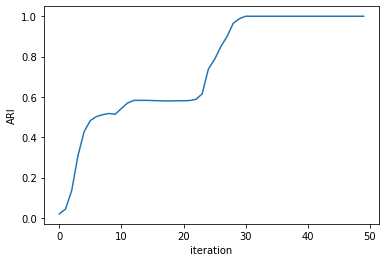

In [19]:
import numpy as np
from scipy.stats import  wishart, dirichlet 
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import adjusted_rand_score as ari


############################## Loading a Data Set ##############################
print("Loading a Data Set")
x_nd_1 = np.loadtxt("./data1.txt") # Observation1(Corresponds to x_1 in the graphical model)
z_truth_n = np.loadtxt("./true_label.txt") # True label (True z_n)
K = 3 # Number of clusters
D = len(x_nd_1) # Number of data
dim = len(x_nd_1[0]) # Number of dimention
print(f"Number of clusters: {K}"); print(f"Number of data: {len(x_nd_1)}"); 
iteration = 50 # Iteration of gibbssampling
ARI = np.zeros((iteration)) # ARI per iteration


############################## Initializing parameters ##############################
# Please refer to the graphical model in README.
print("Initializing parameters")

# Set hyperparameters
alpha_k = np.repeat(2.0, K) # Hyperparameters for \pi
beta = 1.0; 
m_d_1 = np.repeat(0.0, dim); # Hyperparameters for \mu^A, \mu^B
w_dd_1 = np.identity(dim) * 0.05; # Hyperparameters for \Lambda^A, \Lambda^B
nu = dim # Hyperparameters for \Lambda^A, \Lambda^B (nu > Number of dimention - 1)

# Initializing \pi
pi_k = dirichlet.rvs(alpha=alpha_k, size=1).flatten()
alpha_hat_k = np.zeros(K)

# Initializing z
z_nk = np.zeros((D, K)) 
z_nk = np.random.multinomial(n=1, pvals=pi_k, size=D)
_, z_n = np.where(z_nk == 1)

# Initializing unsampled \mu, \Lambda
mu_kd_1 = np.empty((K, dim)); lambda_kdd_1 = np.empty((K, dim, dim))

# Initializing learning parameters
eta_nk = np.zeros((D, K))
beta_hat_k_1 = np.zeros(K);
m_hat_kd_1 = np.zeros((K, dim)); 
w_hat_kdd_1 = np.zeros((K, dim, dim)); 
nu_hat_k_1 = np.zeros(K); 



############################## Gibbssampling ##############################
print("Gibbssampling")
for i in range(iteration):
    print(f"----------------------Iteration : {i+1}------------------------")
    z_pred_n = [] # Labels estimated by the model
    
    # Process on sampling \mu, \lambda
    for k in range(K):
        # Calculate the parameters of the posterior distribution of \mu
        beta_hat_k_1[k] = np.sum(z_nk[:, k]) + beta; 
        m_hat_kd_1[k] = np.sum(z_nk[:, k] * x_nd_1.T, axis=1); 
        m_hat_kd_1[k] += beta * m_d_1; 
        m_hat_kd_1[k] /= beta_hat_k_1[k]; 

        
        # Calculate the parameters of the posterior distribution of \Lambda
        tmp_w_dd_1 = np.dot((z_nk[:, k] * x_nd_1.T), x_nd_1); 
        tmp_w_dd_1 += beta * np.dot(m_d_1.reshape(dim, 1), m_d_1.reshape(1, dim)); 
        tmp_w_dd_1 -= beta_hat_k_1[k] * np.dot(m_hat_kd_1[k].reshape(dim, 1), m_hat_kd_1[k].reshape(1, dim))
        tmp_w_dd_1 += np.linalg.inv(w_dd_1); 
        w_hat_kdd_1[k] = np.linalg.inv(tmp_w_dd_1); 
        nu_hat_k_1[k] = np.sum(z_nk[:, k]) + nu
        
        # Sampling \Lambda
        lambda_kdd_1[k] = wishart.rvs(size=1, df=nu_hat_k_1[k], scale=w_hat_kdd_1[k])
        
        # Sampling \mu
        mu_kd_1[k] = np.random.multivariate_normal(
            mean=m_hat_kd_1[k], cov=np.linalg.inv(beta_hat_k_1[k] * lambda_kdd_1[k]), size=1
        ).flatten()
    
    
    # Process on sampling \pi
    # Calculate the parameters of the posterior distribution of \pi
    alpha_hat_k = np.sum(z_nk, axis=0) + alpha_k
    
    # Sampling \pi
    pi_k = dirichlet.rvs(size=1, alpha=alpha_hat_k).flatten()


    # Process on sampling z
    # Calculate the parameters of the posterior distribution of z
    for k in range(K):
        tmp_eta_n = np.diag(
            -0.5 * (x_nd_1 - mu_kd_1[k]).dot(lambda_kdd_1[k]).dot((x_nd_1 - mu_kd_1[k]).T)
        ).copy() 
        tmp_eta_n += 0.5 * np.log(np.linalg.det(lambda_kdd_1[k]) + 1e-7)
        tmp_eta_n += np.log(pi_k[k] + 1e-7) 
        eta_nk[:, k] = np.exp(tmp_eta_n)
    eta_nk /= np.sum(eta_nk, axis=1, keepdims=True) # Normalization
    
    # Sampling z
    for d in range(D):
        z_nk[d] = np.random.multinomial(n=1, pvals=eta_nk[d], size=1).flatten()
        z_pred_n.append(np.argmax(z_nk[d])) # Append labels estimated by gmm
    
    # Calculate ARI
    ARI[i] = np.round(ari(z_truth_n, z_pred_n), 3)
    print(f"ARI:{ARI[i]}")



# plot ARI
plt.plot(range(0,iteration), ARI, marker="None")
plt.xlabel('iteration')
plt.ylabel('ARI')
#plt.savefig("./image/ari.png")
plt.show()
plt.close()